In [5]:
import numpy as np
import scipy.stats as sp 
import scipy.stats as stats
import matplotlib.pyplot as mp
from matplotlib.ticker import PercentFormatter
import shapely.geometry as sgeom


import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from pprint import pprint

<hr>
Set up datasets
<hr>

In [6]:
run_info =  {}


# Dir if on casper/cheyenne
run_info['run_root'] = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/' # LENS root directory
run_info['run_freq'] = 'monthly' #Frequency to analyze

# Dir if on CGD/thorodin
#run_info['run_root'] = '/project/mojave/cesm1/LENS/atm/' # LENS root directory
#run_info['run_freq'] = 'month_1' #Frequency to analyze




run_info['run_pref'] = ['b.e11.B20TRC5CNBDRD.f09_g16','b.e11.BRCP85C5CNBDRD.f09_g16'] # File prefix


#run_info['run_suff'] = '192001-200512' #File suffix
run_info['run_suff'] = '208101-210012' #File suffix

run_info['run_var'] = 'PRECT' #Variable
run_info['run_yrs'] =  (2081,2100) #First/last years to grab
run_info['run_period'] =  ('June','July','August','September') # Monthly to consider
run_info['run_ens'] = (2,20) # First and last ensemble member

run_info['run_reg'] = np.array([31,37,246,257]) # Lat/on  ranges for averaging
#run_info['run_reg'] = np.array([-15,15,120,160]) # Lat/on  ranges for averaging

<hr>
Loop Cases
<hr>

** ens num,name =  0 002


TypeError: can only concatenate str (not "list") to str

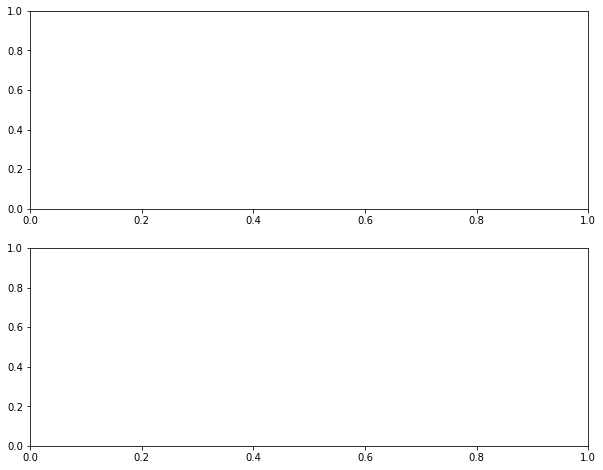

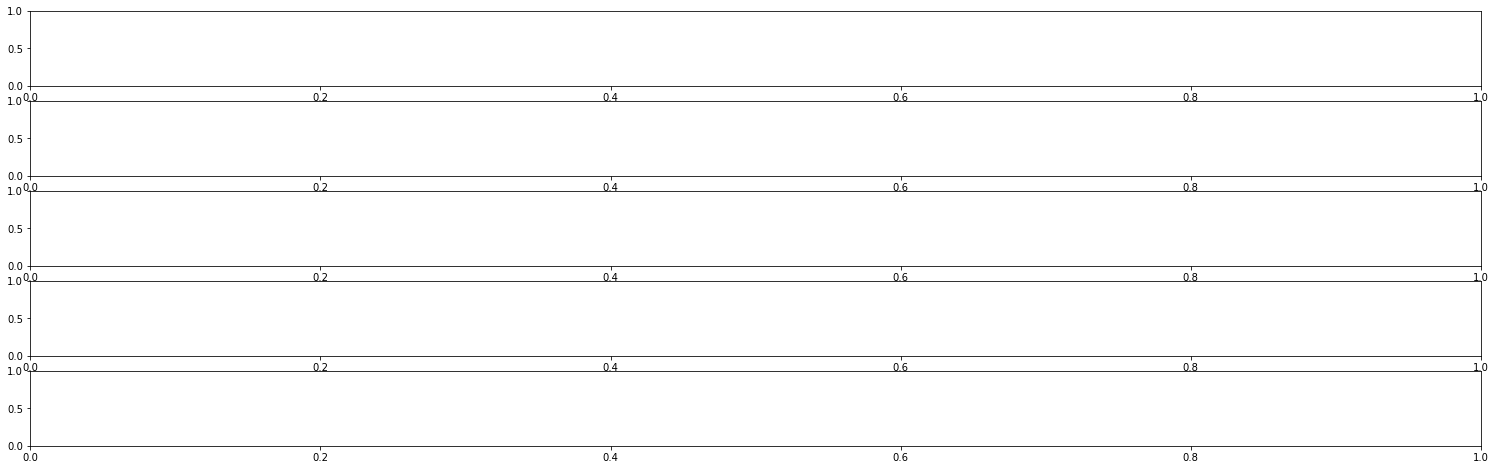

In [8]:
##################################
run_root = run_info['run_root']
run_freq = run_info['run_freq']
run_pref = run_info['run_pref']
run_var  = run_info['run_var']
run_ens  = run_info['run_ens']
run_suff  = run_info['run_suff']
run_yrs = run_info['run_yrs']
run_period = run_info['run_period']
run_reg = run_info['run_reg']

# OBS
obs_root = '/glade/work/rneale/data/NOAA_CPC_USA/'

nmonths = len(run_period)
vscale = 86400*1000.

# Regions in string
reg_a_out = '%d-%dW_%.1f-%dN' % (360-run_reg[2],360-run_reg[3],run_reg[0],run_reg[1])


# Ensemble number/name array #
run_nums = np.arange(run_ens[0],run_ens[1]+1,1) # Wierdly needs run_ens+1
var_tav_ens = False




#var_tav_ens = None
fig, ax = mp.subplots(2,figsize=(10, 8))
fig_ts, ax_ts = mp.subplots(5,figsize=(26, 8))

### Loop Cases ###

for ir,rname in enumerate(run_nums):
   
    rname = '{:03}'.format(rname) # Format for ens# in LENS
    


    print('** ens num,name = ', ir,rname)
    
# Regional/temporal data selection

    if run_var=='PRECT':
        run_file_c = run_root+run_freq+'/PRECC/'+run_pref+'.'+str(rname)+'.cam.h0.PRECC.'+run_suff+'.nc'
        run_obj_c = xr.open_dataset(run_file_c,engine='netcdf4')
    
        run_file_l = run_root+run_freq+'/PRECL/'+run_pref+'.'+str(rname)+'.cam.h0.PRECL.'+run_suff+'.nc'
        run_obj_l = xr.open_dataset(run_file_l,engine='netcdf4')
        
        var_c = run_obj_c['PRECC'].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
        var_l = run_obj_l['PRECL'].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
        var = var_c+var_l
    else :
        run_file = run_root+run_freq+'/'+run_var+'/'+run_pref+'.'+str(rname)+'.cam.h0.'+run_var+'.'+run_suff+'.nc'
        run_obj = xr.open_dataset(run_file,engine='netcdf4')
        var = run_obj[run_var].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
    
    var = var*vscale
    
# Latitude (weighted) and longitude averaging
    gw_lat = np.cos(np.deg2rad(var.lat.values))  # Latitude weights
    var_av = (var * gw_lat[None, :, None]).sum(dim='lat') / np.sum(gw_lat)
    var_av = var_av.mean('lon')

# Time average (month or season)
    if ir==0:
        time = var.time # Read time
        months = time.dt.month # Array of months number
        mon_name = time.dt.strftime('%B') # Array of month names
        ptime = time.dt.year+(time.time.dt.month-1)/12 # Fraction of year (jan=0). x-axis on tseries plots
        pyear = time.dt.year # Just brab year array for tseries plots

# Tricky: extract tuple of arrays for points for
   
    if ir>0 : var_tav_prev = var_tav_tup # Set to previous value so we can append new run to this.
    var_tav_tup = () # Reset for this run
    
    for im in range(len(run_period)):
        im4ave = np.where(mon_name==run_period[im]) # Indices for this month
        var_tav = var_av[im4ave] # Values each year for this month
         
        ax_ts[im].plot(np.unique(pyear),var_tav) # Plot against just single years, for each month
        
        if ir==0 :
            var_tav_now = var_tav
        else :
            var_tav_now = np.concatenate((var_tav_prev[im],var_tav),axis=0)
                       
        var_tav_tup = var_tav_tup+(var_tav_now,) # Add to tuple for plotting
     
    
    
# PDF PLot using all runs.
num_bins = 40
bin_range = (0,4)

ax[0].hist(var_tav_tup, num_bins, histtype=u'step', label = run_period, density=True, range=bin_range)    
#ax[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax[0].set_xlabel('Precipitation Rate (mm/day)')   
ax[0].set_ylabel('# Years')  
ax[0].set_xlim([0.,4.]) 
ax[0].set_ylim([0.,1.5])  

#for ipp in range(nmonths):
#    print(ipp)
#    density = stats.gaussian_kde(var_tav_tup[ipp])
#    nn, xx, _ = ax[0].hist(var_tav_tup[ipp], num_bins, histtype='bar', label = run_period)    
#    print(xx)
#    ax[1].plot(xx,density(xx[i]))

ax[0].legend()


#############################
###### Observations #########
#############################

obs_file = obs_root+'precip.V1.0.mon.mean.nc'
obs_obj = xr.open_dataset(obs_file,engine='netcdf4')
ovar = obs_obj['precip'].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 


# Latitude (weighted) and longitude averaging
ogw_lat = np.cos(np.deg2rad(ovar.lat.values))  # Latitude weights
ovar_av = (ovar * ogw_lat[None, :, None]).sum(dim='lat') / np.sum(ogw_lat)
ovar_av = ovar_av.mean('lon')

# Obs. time

time = ovar.time # Read time
months = time.dt.month # Array of months number

mon_name = time.dt.strftime('%B') # Array of month names
ptime = time.dt.year+(time.time.dt.month-1)/12 # Fraction of year (jan=0). x-axis on tseries plots
pyear = time.dt.year # Just brab year array for tseries plots

obs_tav_tup = () # Reset for this run
    
# Accumlate    
for im in range(len(run_period)):
    im4ave = np.where(mon_name==run_period[im]) # Indices for this month

    obs_tav = ovar_av[im4ave] # Values each year for this month
         
#    ax_ts[im].plot(np.unique(pyear),var_tav) # Plot against just single years, for each month
        
#    if im==0 :
    obs_tav_now = obs_tav
#    else :
#        obs_tav_now = np.concatenate((obs_tav_prev[im],obs_tav),axis=0)
                       
    obs_tav_tup = obs_tav_tup+(obs_tav_now,) # Add to tuple for plotting

    
ax[1].hist(obs_tav_tup, num_bins, histtype=u'step', label = run_period, density=True, range=bin_range)    


#ax[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax[1].set_xlabel('Precipitation Rate (mm/day)')   
ax[1].set_ylabel('# Years')  

ax[1].set_xlim([0.,4.]) 
ax[1].set_ylim([0.,1.5])  
    
mp.savefig('monsoon_months_out_'+reg_a_out+'_'+month_ave[0]+'_to_'+month_ave[0]+'.png', dpi=300)
    
### PLOT AVERAGING MAP REGION ####

## Plot map with averaging location

figm = mp.figure()

axm = figm.add_subplot(projection=ccrs.PlateCarree())

r1 = run_reg[2] if run_reg[3] <=180. else run_reg[2]-360.
r2 = run_reg[0] 
r3 = run_reg[3] if run_reg[3] <=180. else run_reg[3]-360.
r4 = run_reg[1] 


print('-- Region -> ',r1,r2,r3,r4)
print('')

extent_box = sgeom.box(r1,r2,r3,r4)

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)
axm.add_geometries(shpreader.Reader(states_shp).geometries(),ccrs.PlateCarree(),edgecolor='black')

axm.set_extent([-130, -90, 25,50], crs=ccrs.PlateCarree())
axm.add_geometries([extent_box], ccrs.PlateCarree(), facecolor='none',
                          edgecolor='red', linewidth=2)

#axm.add_feature(cfeature.LAND)
#axm.add_feature(cfeature.COASTLINE)
mp.show()
    
    
#CDF too!

     
    
  

<hr>
Plotting
<hr>